##**Предсказание стиля вождения**

Агрессивное вождение может приводить к опасным ситуациям на дороге. Предсказание стиля вождения может быть полезным в работе страховых компаний, а также транспортных служб. В данной задаче необходимо предсказать один из трех стилей вождения, основываясь на характеристиках транспортного средства, скорости езды, характеристике транспортного потока и погодных условиях.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#%config InlineBackend.figure_format = 'svg'
import sklearn 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###1. Загрузка данных

Данные представлены в трех файлах:


*   Train.csv - содержит общую информацию о транспортном средстве
*   Train_Vehicletravellingdata.csv - содержит информацию о поездке
*   Train_WeatherData.csv - содержит информацию о погодных условиях во время поездки



In [2]:
!unzip dataset.zip

Archive:  dataset.zip
  inflating: Train.csv               
  inflating: Train_Vehicletravellingdata.csv  
  inflating: Train_WeatherData.csv   


In [3]:
car_info = pd.read_csv("Train.csv")

In [4]:
car_info.shape

(12994, 5)

In [5]:
car_info.head()

,ID,V2,V5,V6,DrivingStyle
0,DR_24526,1265,10243,2,2
1,DR_30052,1680,30871,6,2
2,DR_40928,936,3224,4,2
3,DR_66033,1503,3315,4,2
4,DR_45266,929,3022,4,2


`ID` - идентификатор транспортного средства <br>
`V2` - длина транспортного средства в см <br>
`V5` - вес транспортного средства в кг <br>
`V6` - количество осей <br>
`DrivingStyle` - стиль вождения, целевая переменная <br>
*   Aggressive (1) - агрессивный
*   Normal (2) - нормальный
*   Vague (3) - переменчивый





In [6]:
car_info.rename(columns={"V2":"length", "V5":"weight", "V6":"axles"}, inplace=True)

In [7]:
car_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12994 entries, 0 to 12993
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            12994 non-null  object
 1   length        12994 non-null  int64 
 2   weight        12994 non-null  int64 
 3   axles         12994 non-null  int64 
 4   DrivingStyle  12994 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 507.7+ KB


In [8]:
travel_info = pd.read_csv("Train_Vehicletravellingdata.csv")

In [9]:
travel_info.shape

(162566, 10)

In [10]:
travel_info.head()

,ID,V1,V3,V4,V7,V8,V9,V10,V11,V18
0,DR_24526,2012-03-21 09:14:55,1,81,57227,87,16986,941,94.0,Dry
1,DR_24526,2012-03-21 09:15:07,1,88,57229,81,1708,551,11.0,Dry
2,DR_24526,2012-03-21 09:15:12,1,88,57230,88,22892,1698,4.0,Dry
3,DR_24526,2012-03-21 09:15:48,2,84,57228,89,1945,544,127.0,Dry
4,DR_24526,2012-03-21 09:15:54,1,89,57231,88,13787,1893,42.0,Dry


`ID` - идентификатор транспортного средства <br>
`V1` - дата и время описываемого интервала поездки<br>
`V3` - полоса дороги, по которой движется транспортное средство<br>
`V4` - скорость транспортного средства в км/ч<br>
`V7` - идентификатор предшествующего транспортного средства<br>
`V8` - скорость предшествующего транспортного средства в км/ч<br>
`V9` - вес предшествующего транспортного средства в кг<br>
`V10` - длина предшествующего транспортного средства в см<br>
`V11` - время, через которое транспортное средство оказалость на месте предшествующего, в секундах<br>
`V18` - состояние дороги с учетом погоды
*   Dry - сухое
*   Wet - мокрое
*   Visible tracks - 
*   Snow covered - покрытое снегом


In [11]:
travel_info.rename(columns={"V1":"date_time", "V3":"road_lane", "V4":"speed", "V7":"ID_previous", \
                            "V8":"speed_previous", "V9":"weight_previous", "V10":"length_previous", \
                            "V11":"time_gap", "V18":"road_condition"}, inplace=True)

In [12]:
travel_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162566 entries, 0 to 162565
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               162566 non-null  object 
 1   date_time        162566 non-null  object 
 2   road_lane        162566 non-null  int64  
 3   speed            162566 non-null  int64  
 4   ID_previous      162566 non-null  int64  
 5   speed_previous   162566 non-null  int64  
 6   weight_previous  162566 non-null  int64  
 7   length_previous  162566 non-null  int64  
 8   time_gap         160111 non-null  float64
 9   road_condition   162566 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 12.4+ MB


По признаку `time_gap`можно заметить, что в наборе отсутствуют некоторые значения. Также категориальные признаки представлены типом `object`, заменим их на `category`.

In [13]:
travel_info["road_condition"] = travel_info["road_condition"].astype('category')

In [14]:
weather_info = pd.read_csv("Train_WeatherData.csv")

In [15]:
weather_info.shape

(162566, 9)

In [16]:
weather_info.head()

,ID,V1,V12,V13,V14,V15,V16,V17,V19
0,DR_24526,2012-03-21 09:14:55,7.0,clear,None,95.0,146.0,1.0,daylight
1,DR_24526,2012-03-21 09:15:07,7.0,clear,None,95.0,124.0,0.0,daylight
2,DR_24526,2012-03-21 09:15:12,7.0,clear,None,95.0,124.0,0.0,daylight
3,DR_24526,2012-03-21 09:15:48,7.0,clear,None,95.0,124.0,0.0,daylight
4,DR_24526,2012-03-21 09:15:54,7.0,clear,None,95.0,124.0,0.0,daylight


`ID` - идентификатор транспортного средства <br>
`V1` - дата и время описываемого интервала поездки<br>
`V12` - температура воздуха<br>
`V13` - тип осадков<br>
*   clear - без осадков
*   rain - дождь
*   snow - снег

`V14` - интенсивность осадков<br>

*   None - без осадков
*   Low - низкая (0-1 мм/10 мин)
*   Moderate - умеренная (1-5 мм/10 мин)
*   High - высокая (больше 5 мм/10 мин)
*   " " - пустая строка, вероятно интенсивность до 97%

`V15` - относительная влажность воздуха<br>
`V16` - направление ветра (0-360 градусов)<br>
`V17` - скорость ветра в м/сек<br>
`V19` - условия освещения в зависимости от времени суток
*   daylight - дневной свет
*   night - ночь
*   twilight - сумерки


In [17]:
weather_info.rename(columns={"V12":"temperature", "V13":"precipitation", "V14":"prec_intensity", \
                             "V15":"humidity", "V16":"wind_direct", "V17":"wind_speed", "V19":"light"}, inplace=True)

In [18]:
weather_info.drop(["V1"], axis=1, inplace=True)

In [19]:
weather_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162566 entries, 0 to 162565
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              162566 non-null  object 
 1   temperature     160509 non-null  float64
 2   precipitation   162566 non-null  object 
 3   prec_intensity  162566 non-null  object 
 4   humidity        160461 non-null  float64
 5   wind_direct     160452 non-null  float64
 6   wind_speed      160102 non-null  float64
 7   light           162566 non-null  object 
dtypes: float64(4), object(4)
memory usage: 9.9+ MB


Здесь также есть `object`-признаки и пропущенные значения, которые позднее рассмотрим более детально. 

In [20]:
weather_info["precipitation"] = weather_info["precipitation"].astype('category')
weather_info["prec_intensity"] = weather_info["prec_intensity"].astype('category')
weather_info["light"] = weather_info["light"].astype('category')

Для удобства работы склеим все три датафрема в один на основе идентификатора ТС.

In [21]:
temp_df = car_info.merge(travel_info, on="ID")

In [22]:
driving_df = pd.concat([temp_df, weather_info], axis=1)

In [23]:
driving_df.head()

,ID,length,weight,axles,DrivingStyle,date_time,road_lane,speed,ID_previous,speed_previous,weight_previous,length_previous,time_gap,road_condition,ID,temperature,precipitation,prec_intensity,humidity,wind_direct,wind_speed,light
0,DR_24526,1265,10243,2,2,2012-03-21 09:14:55,1,81,57227,87,16986,941,94.0,Dry,DR_24526,7.0,clear,None,95.0,146.0,1.0,daylight
1,DR_24526,1265,10243,2,2,2012-03-21 09:15:07,1,88,57229,81,1708,551,11.0,Dry,DR_24526,7.0,clear,None,95.0,124.0,0.0,daylight
2,DR_24526,1265,10243,2,2,2012-03-21 09:15:12,1,88,57230,88,22892,1698,4.0,Dry,DR_24526,7.0,clear,None,95.0,124.0,0.0,daylight
3,DR_24526,1265,10243,2,2,2012-03-21 09:15:48,2,84,57228,89,1945,544,127.0,Dry,DR_24526,7.0,clear,None,95.0,124.0,0.0,daylight
4,DR_24526,1265,10243,2,2,2012-03-21 09:15:54,1,89,57231,88,13787,1893,42.0,Dry,DR_24526,7.0,clear,None,95.0,124.0,0.0,daylight


Столбцы `ID` дублируются, к тому же не несут важной информации, поэтому можно удалить их. 

In [24]:
driving_df = driving_df.loc[:,~driving_df.T.duplicated(keep='first')]

In [25]:
driving_df.head()

,ID,length,weight,axles,DrivingStyle,date_time,road_lane,speed,ID_previous,speed_previous,weight_previous,length_previous,time_gap,road_condition,temperature,precipitation,prec_intensity,humidity,wind_direct,wind_speed,light
0,DR_24526,1265,10243,2,2,2012-03-21 09:14:55,1,81,57227,87,16986,941,94.0,Dry,7.0,clear,None,95.0,146.0,1.0,daylight
1,DR_24526,1265,10243,2,2,2012-03-21 09:15:07,1,88,57229,81,1708,551,11.0,Dry,7.0,clear,None,95.0,124.0,0.0,daylight
2,DR_24526,1265,10243,2,2,2012-03-21 09:15:12,1,88,57230,88,22892,1698,4.0,Dry,7.0,clear,None,95.0,124.0,0.0,daylight
3,DR_24526,1265,10243,2,2,2012-03-21 09:15:48,2,84,57228,89,1945,544,127.0,Dry,7.0,clear,None,95.0,124.0,0.0,daylight
4,DR_24526,1265,10243,2,2,2012-03-21 09:15:54,1,89,57231,88,13787,1893,42.0,Dry,7.0,clear,None,95.0,124.0,0.0,daylight


In [26]:
driving_df.shape

(162566, 21)

###2. Визуализация и характеристика данных

In [27]:
driving_df.describe()

,length,weight,axles,DrivingStyle,road_lane,speed,ID_previous,speed_previous,weight_previous,length_previous,time_gap,temperature,humidity,wind_direct,wind_speed
count,162566.000000,162566.000000,162566.000000,162566.000000,162566.000000,162566.000000,162566.000000,162566.000000,162566.000000,162566.000000,160111.000000,160509.000000,160461.000000,160452.000000,160102.000000
mean,865.518349,6020.270481,2.846315,2.147263,1.500849,83.455483,460124.263979,83.458817,5017.562793,790.775285,105.340358,4.654237,60.647509,182.461178,4.188648
std,495.155881,7972.925231,1.466560,0.668102,0.500001,9.375122,272271.224195,9.373120,7399.315434,481.944297,177.202269,3.226701,18.272899,88.927865,3.027595
min,155.000000,44.000000,2.000000,1.000000,1.000000,8.000000,20.000000,0.000000,3.000000,102.000000,1.000000,-13.000000,16.000000,6.000000,0.000000
25%,550.000000,1625.000000,2.000000,2.000000,1.000000,78.000000,142983.250000,78.000000,1502.000000,527.000000,7.000000,2.000000,46.000000,152.000000,1.000000
50%,577.000000,2013.000000,2.000000,2.000000,2.000000,83.000000,594321.500000,83.000000,1862.000000,560.000000,43.000000,5.000000,58.000000,180.000000,4.000000
75%,1060.000000,6220.000000,3.000000,3.000000,2.000000,88.000000,692362.750000,88.000000,2669.000000,701.000000,125.000000,7.000000,76.000000,208.000000,7.000000
max,2337.000000,57230.000000,9.000000,3.000000,2.000000,161.000000,794435.000000,161.000000,69548.000000,2981.000000,1797.000000,24.000000,97.000000,360.000000,17.000000


Минимальное значение признака `weight` равно 44 кг. Возможно, это выброс, или в датасете присутствуют мопеды или детские машинки. Построим график зависимости длины и веса ТС.


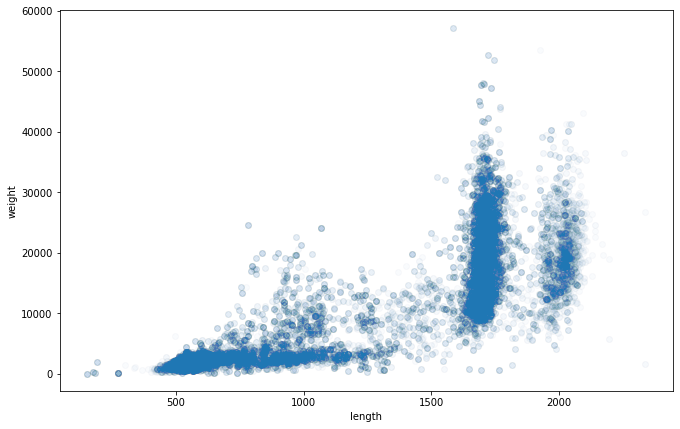

In [28]:
plt.figure(figsize=(11, 7))
plt.scatter(driving_df['length'], driving_df['weight'], alpha=0.01)
plt.xlabel("length")
plt.ylabel("weight")
pass

Можно заметить, что транспортные средства образуют 3 большие группы по размеру. Так как маленькому весу соответсвует маленькая длина, скорее всего это мопеды. Однако есть также отдельные точки, соответвующие максимально большой длине (больше 23 метров) и весу около 1.5 тонны, это уже неправдоподобно, а значит, является выбросами.

In [29]:
driving_df[driving_df['length']>2300]

,ID,length,weight,axles,DrivingStyle,date_time,road_lane,speed,ID_previous,speed_previous,weight_previous,length_previous,time_gap,road_condition,temperature,precipitation,prec_intensity,humidity,wind_direct,wind_speed,light
79729,DR_24854,2335,26809,6,1,2012-12-07 03:50:05,2,88,590650,89,26810,1710,1087.0,Dry,1.0,clear,None,57.0,197.0,3.0,night
79730,DR_24854,2335,26809,6,1,2012-12-07 03:50:57,1,90,590655,78,1821,580,348.0,Dry,1.0,clear,None,57.0,197.0,3.0,night
92876,DR_64769,2337,1630,5,3,2013-01-02 22:32:56,1,89,625996,87,2363,593,204.0,Wet,4.0,clear,None,60.0,174.0,5.0,night
92877,DR_64769,2337,1630,5,3,2013-01-02 22:38:29,1,79,625997,89,2296,533,332.0,Wet,9.0,clear,None,57.0,208.0,6.0,night
92878,DR_64769,2337,1630,5,3,2013-01-02 22:38:30,2,79,625992,82,6103,801,668.0,Wet,9.0,clear,None,57.0,208.0,6.0,night


Количество осей также показывает размер транспортного средства

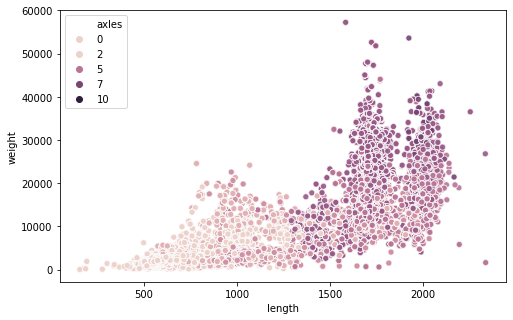

In [30]:
plt.figure(figsize = (8, 5))
sns.scatterplot(x='length', y='weight', hue='axles', data=driving_df, alpha=0.7)
pass

In [31]:
driving_df['length'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005     482.0
0.010     493.0
0.050     521.0
0.100     532.0
0.500     577.0
0.900    1716.0
0.950    1760.0
0.990    2029.0
0.995    2047.0
Name: length, dtype: float64

In [32]:
driving_df['weight'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005      618.0
0.010      820.0
0.050     1210.0
0.100     1372.0
0.500     2013.0
0.900    19683.0
0.950    24252.0
0.990    31724.0
0.995    34386.0
Name: weight, dtype: float64

Удалим данные, где `length` выходит за пределы квантиля 0.995 и `weight` - за пределы квантиля 0.005



In [33]:
rows_to_drop = driving_df[
    (driving_df['weight'] < driving_df['weight'].quantile(0.500)) & (driving_df['length'] > driving_df['length'].quantile(0.995))].index
driving_df.drop(rows_to_drop, inplace=True)

In [34]:
rows_to_drop

Int64Index([92876, 92877, 92878], dtype='int64')

Минимальное значение признака `weight_previous` равно 3 кг, и это наверняка выброс. Судя по маленьким значениям признаков `length_previous` и `weight_previous`, это не мопеды и не мотоциклы.

In [35]:
driving_df[driving_df['weight_previous']<30]

,ID,length,weight,axles,DrivingStyle,date_time,road_lane,speed,ID_previous,speed_previous,weight_previous,length_previous,time_gap,road_condition,temperature,precipitation,prec_intensity,humidity,wind_direct,wind_speed,light
40557,DR_70111,505,1118,2,2,2012-05-09 13:46:31,1,73,142934,0,3,555,85.0,Dry,6.0,clear,None,32.0,169.0,2.0,daylight
66303,DR_59129,571,1270,2,2,2012-11-11 10:39:27,2,107,558397,21,19,120,109.0,Wet,4.0,clear,None,80.0,197.0,1.0,daylight


In [36]:
rows_to_drop = driving_df[driving_df['weight_previous']<30].index
driving_df.drop(rows_to_drop, inplace=True)

In [37]:
driving_df.describe(include=['category'])

,road_condition,precipitation,prec_intensity,light
count,162561,162561,162561,162561
unique,4,3,5,3
top,Dry,clear,None,night
freq,117665,151254,151570,95922


По категориальным признакам ничего подозрительного не видно.

Посмотрим зависимость стиля вождения (целевой переменной) от скорости ТС.

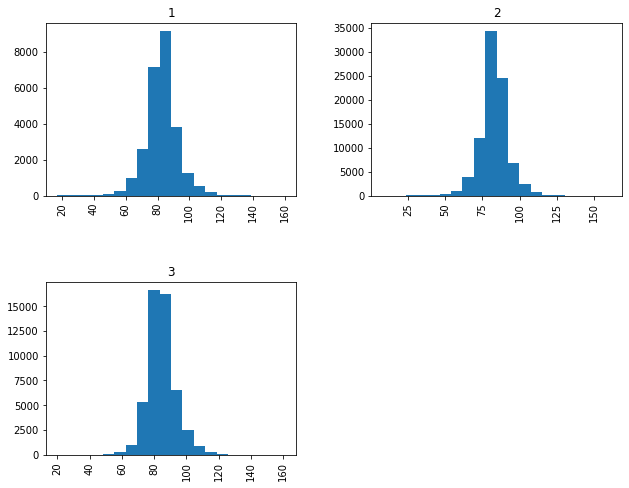

In [38]:
driving_df[['speed']].hist(by=driving_df['DrivingStyle'], figsize=(10,8), sharex=False, bins=20)
plt.show()

In [39]:
driving_df.groupby(by='DrivingStyle')['speed'].median()

DrivingStyle
1    83
2    83
3    84
Name: speed, dtype: int64

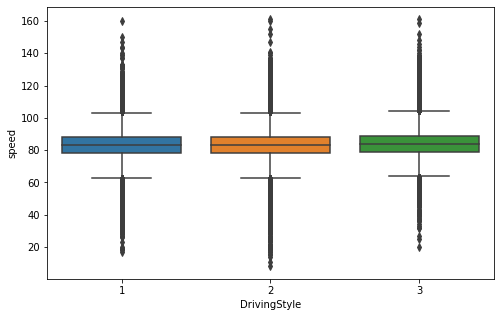

In [40]:
plt.figure(figsize=(8,5))
sns.boxplot(x="DrivingStyle", y="speed", data=driving_df)
pass

Судя по распрделениям скорости для каждлого типа вождения, скорость не является характеризующим фактором для агрессивного вождения. Медианные значения скоростей также одинаковые для разных типов. <br>
Агрессивное вождение можно характеризовать частой сменой скорости (резкие торможения и резкие ускорения). Поэтому создадим еще один признак, обозначающий разницу в скоростях между двумя парами промежутков времени поездки для каждого транспортного средства.

In [41]:
ids = car_info["ID"]
ids.values

array(['DR_24526', 'DR_30052', 'DR_40928', ..., 'DR_61590', 'DR_69505',
       'DR_56117'], dtype=object)

In [42]:
result = {}
ids_list = []
deltas = []
for id in ids:
  speeds_arr = driving_df[driving_df["ID"] == id]["speed"]
  total_delta = 0
  for i in range(1, len(speeds_arr)):
      total_delta += abs(speeds_arr.iloc[i] - speeds_arr.iloc[i - 1])
  delta = total_delta / (len(speeds_arr) - 1)
  ids_list.append(id)
  deltas.append(delta)
result.update({"ID": ids_list})
result.update({"delta": deltas})

In [43]:
delta_df = pd.DataFrame(data=result)
new_car_info = pd.concat([car_info, delta_df],axis=1)

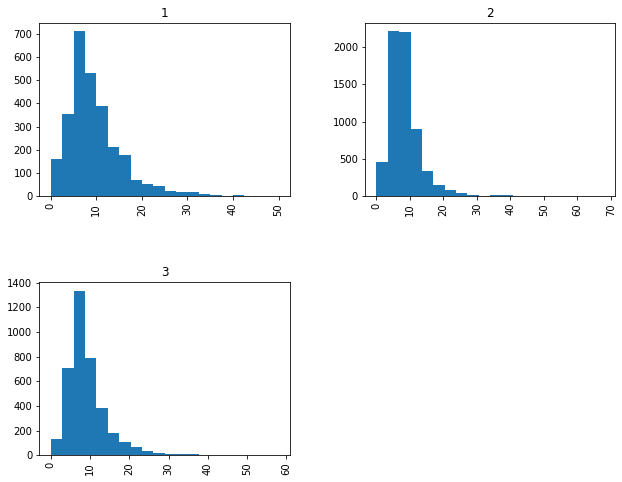

In [44]:
new_car_info[['delta']].hist(by=new_car_info['DrivingStyle'], figsize=(10,8), sharex=False, bins=20)
plt.show()

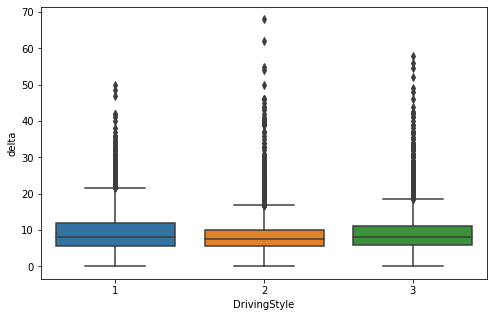

In [45]:
plt.figure(figsize=(8,5))
sns.boxplot(x="DrivingStyle", y="delta", data=new_car_info)
pass

In [46]:
new_car_info.groupby(by='DrivingStyle')['delta'].median()

DrivingStyle
1    8.076923
2    7.472136
3    8.000000
Name: delta, dtype: float64

Здесь уже наблюдаются явные различия: разброс дельт для агрессивного типа вождения (1) больше, чем для нормального (2) и переменчивого (3). Для нормального типа чаще характерно стабильное изменения скорости с некоторыми выбросами, в то время как у агрессивного типа наблюдается больший разброс значений

In [47]:
result = {}
ids_list = []
deltas = []
for id in driving_df['ID'].unique():
  speeds_arr = driving_df[driving_df["ID"] == id]["speed"]
  total_delta = 0
  ids_list.append(id)
  deltas.append(0) 
  for i in range(1, len(speeds_arr)):
      delta = abs(speeds_arr.iloc[i] - speeds_arr.iloc[i - 1])
      ids_list.append(id)
      deltas.append(delta)
result.update({"ID": ids_list})
result.update({"delta": deltas})

In [48]:
delta_df =  pd.DataFrame(data=result)

In [49]:
driving_df.reset_index(drop=True, inplace=True)

In [50]:
driving_df.index

RangeIndex(start=0, stop=162561, step=1)

In [51]:
delta_df.index

RangeIndex(start=0, stop=162561, step=1)

In [52]:
driving_df = pd.concat([driving_df, delta_df], axis=1)

In [53]:
driving_df.head()

,ID,length,weight,axles,DrivingStyle,date_time,road_lane,speed,ID_previous,speed_previous,weight_previous,length_previous,time_gap,road_condition,temperature,precipitation,prec_intensity,humidity,wind_direct,wind_speed,light,ID,delta
0,DR_24526,1265,10243,2,2,2012-03-21 09:14:55,1,81,57227,87,16986,941,94.0,Dry,7.0,clear,None,95.0,146.0,1.0,daylight,DR_24526,0
1,DR_24526,1265,10243,2,2,2012-03-21 09:15:07,1,88,57229,81,1708,551,11.0,Dry,7.0,clear,None,95.0,124.0,0.0,daylight,DR_24526,7
2,DR_24526,1265,10243,2,2,2012-03-21 09:15:12,1,88,57230,88,22892,1698,4.0,Dry,7.0,clear,None,95.0,124.0,0.0,daylight,DR_24526,0
3,DR_24526,1265,10243,2,2,2012-03-21 09:15:48,2,84,57228,89,1945,544,127.0,Dry,7.0,clear,None,95.0,124.0,0.0,daylight,DR_24526,4
4,DR_24526,1265,10243,2,2,2012-03-21 09:15:54,1,89,57231,88,13787,1893,42.0,Dry,7.0,clear,None,95.0,124.0,0.0,daylight,DR_24526,5


In [54]:
driving_df.drop(["ID", "ID_previous", "speed", "date_time"], axis=1, inplace=True)

In [55]:
driving_df.shape

(162561, 18)

In [56]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(driving_df.shape[0]), size=1000, replace=False)

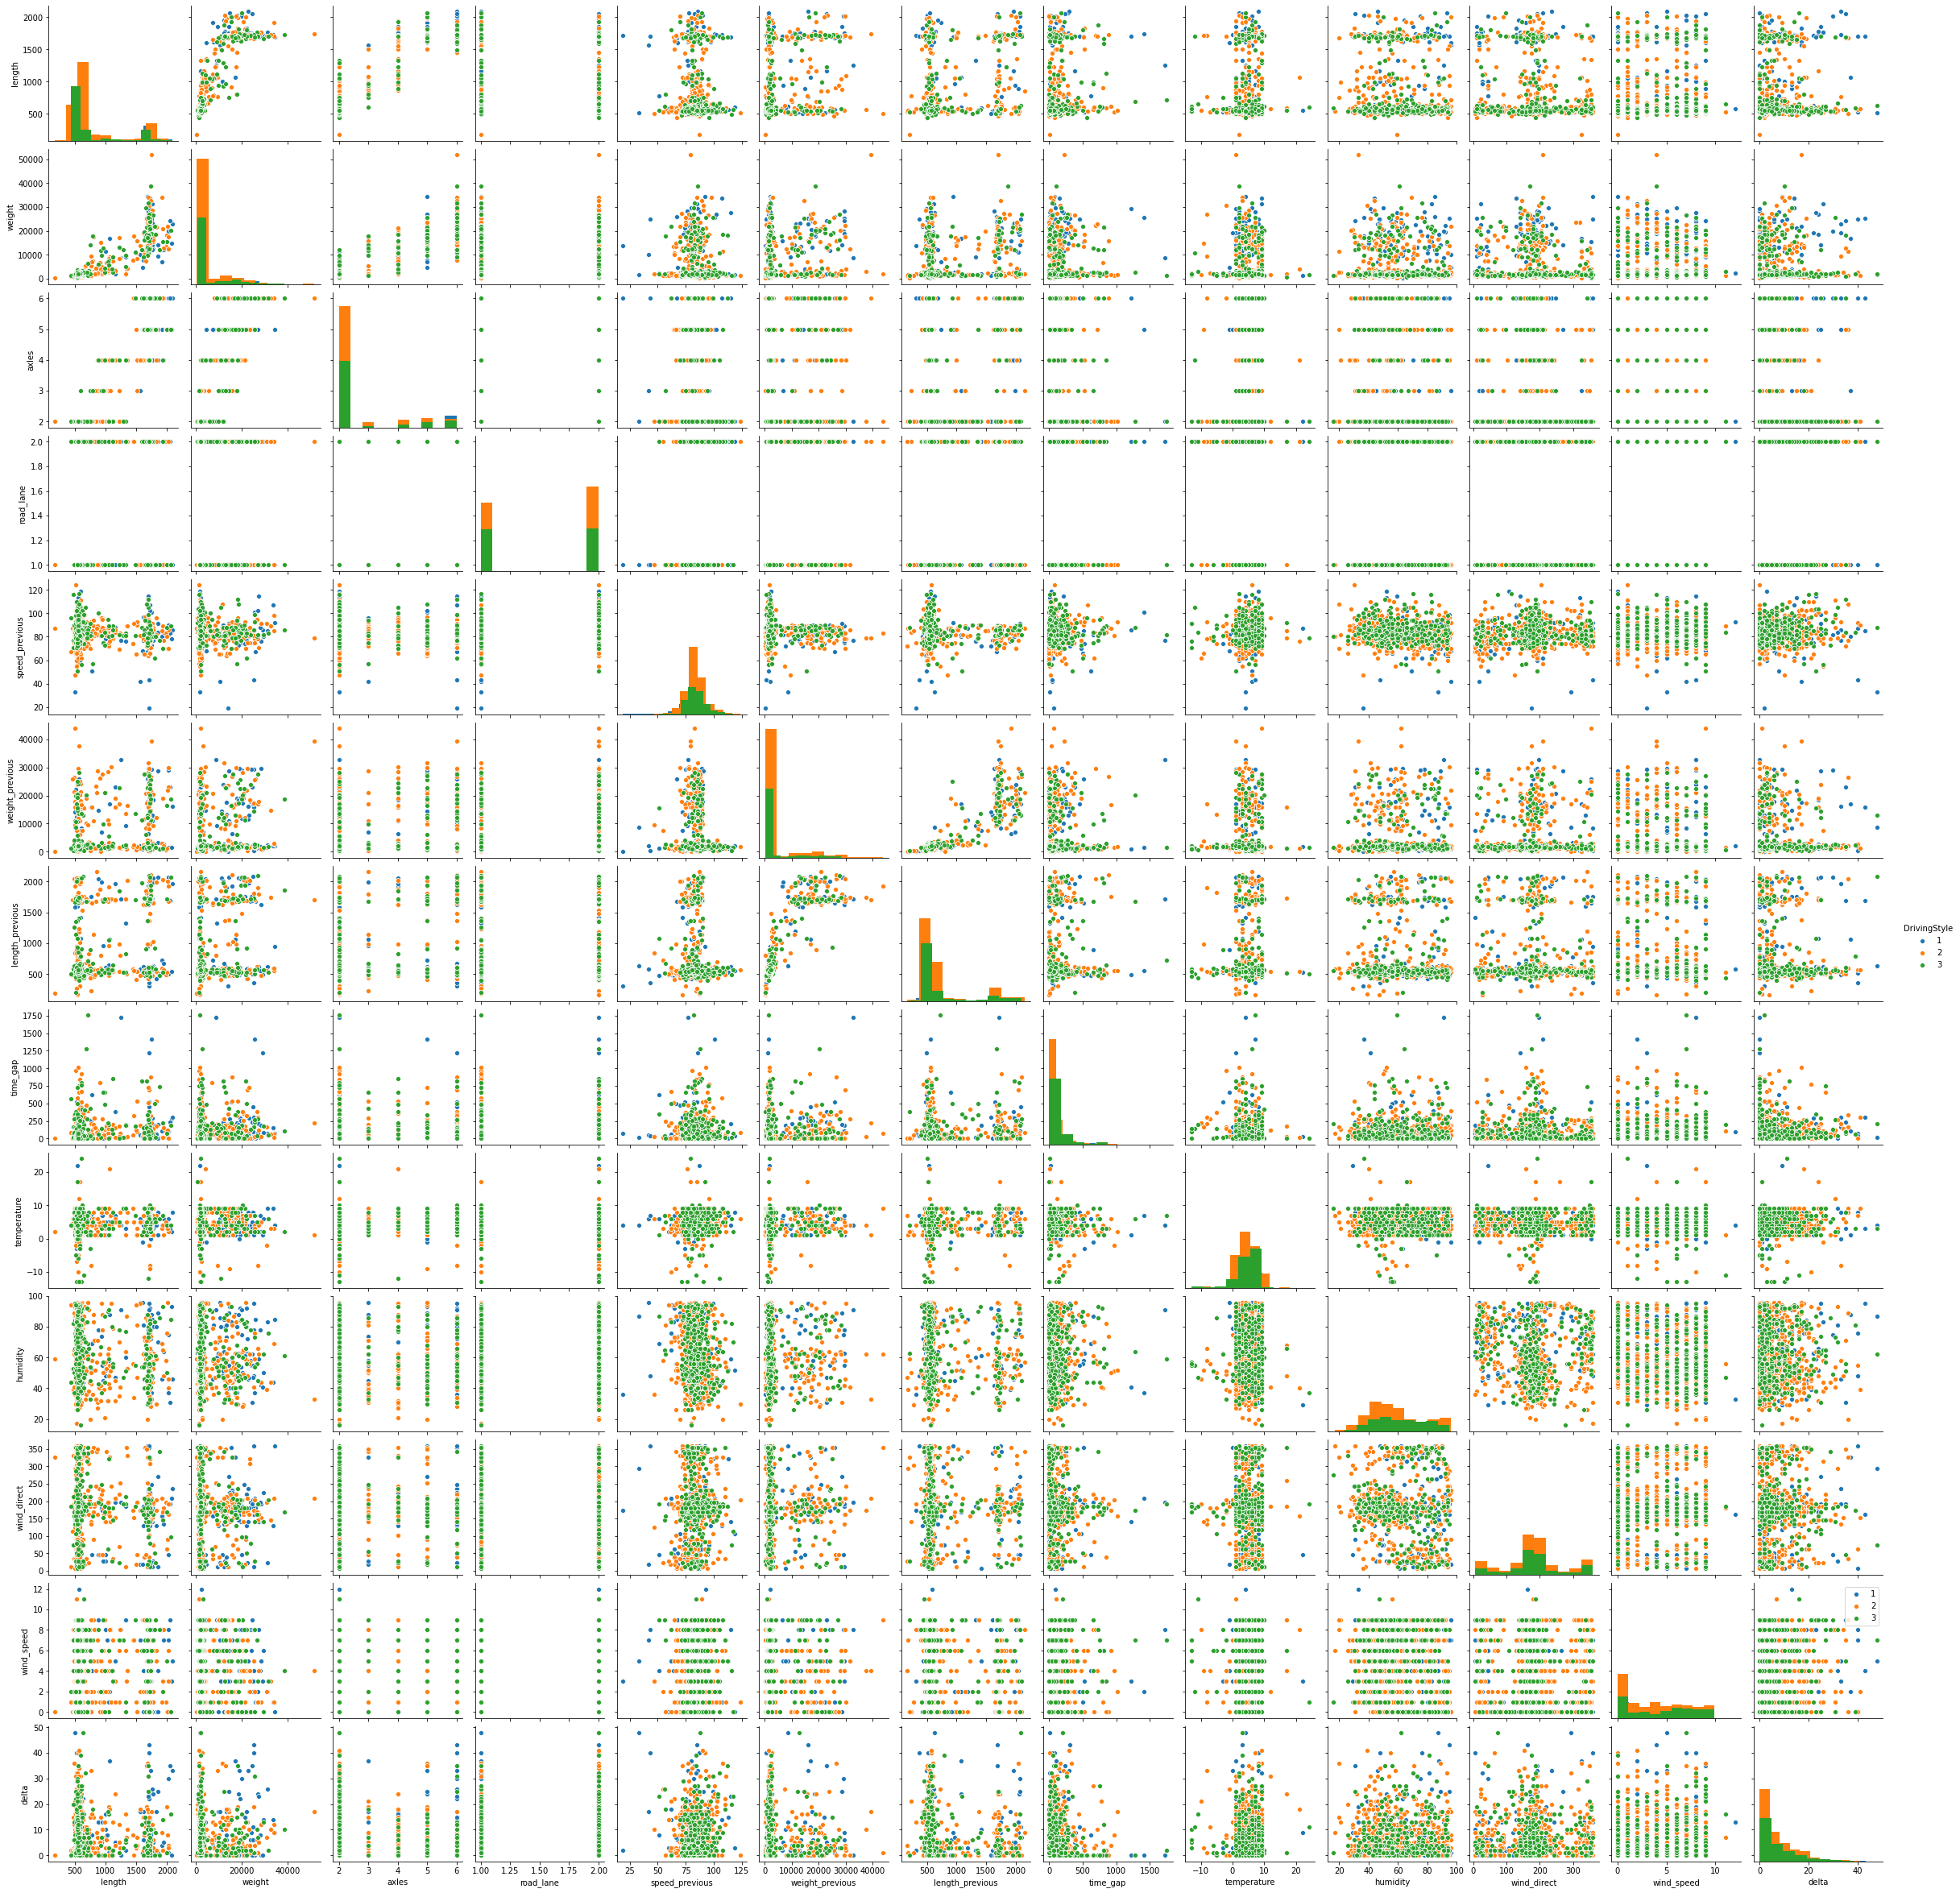

In [57]:
sns.pairplot(driving_df.iloc[random_subset], hue='DrivingStyle', diag_kind='hist')
plt.legend()
pass

Встречаются случаи, когда транспортные средства, имеющие большую длину и вес, значительно меняют скорость во время езды (агрессивные дальнобойщики). Временной интервал между ними и предшествующими машинами чаще значительный, но бывает и коротким, что также создает опасные ситуации на дороге. Часто агрессивным вождение становится в условиях высокой влажности, так как водители крупногабартиных ТС не сбавляют привычный темп, который был бы приемлем в обычных условиях (об этом также говорят высокие перепады скорости) <br>
При сильном ветре аварийные ситуации иогут создавать как крупногабаритные, так и малогабаритные тс, однако некоторые стараются держаться дистанции. <br>
Общая тендения такова, что за крупногабартиными машинами все едут агрессивнее, так как возможно стараются их обогнать. 

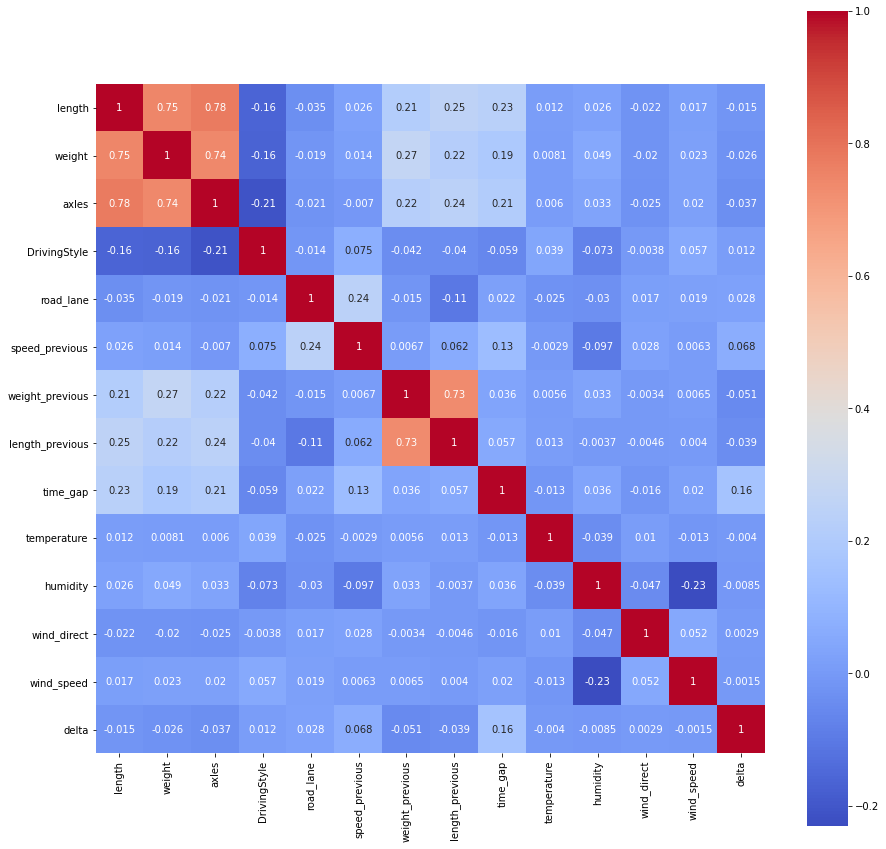

In [58]:
corr_mat = driving_df.corr(method='spearman')
plt.figure(figsize=(15,15))
sns.heatmap(corr_mat, square=True, cmap='coolwarm', annot=True)
pass

Очевидно, что длина, вес и количество осей ТС будут сильно коррелировать. При этом они сильнее остальных коррелируют с целевой переменной. Так как мы не используем линейные модели, пока не будем удалять эти признаки.

Посмотрим на категориальные признаки относительно целевой переменной.

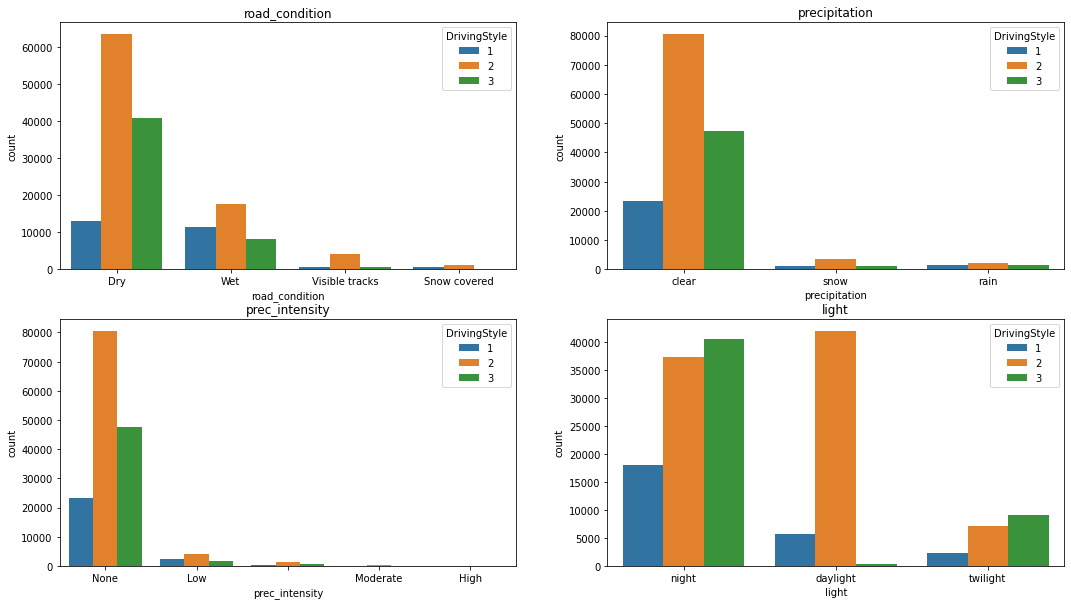

In [59]:
cat_features = ["road_condition", "precipitation", "prec_intensity",	"light"]
plt.figure(figsize=(18,10))
for i in range(len(cat_features)):
  plt.subplot(2,2, i+1)
  sns.countplot(x=cat_features[i], order=driving_df[cat_features[i]].value_counts().index, hue='DrivingStyle', data=driving_df)
  plt.title(cat_features[i])
pass

Большинство наблюдений в датасете собрано в хорошую погоду. Классы при этом распределяются примерно в равных пропорциях относительно их основного распределения. Исключением является признак `light`: вечером и ночью большинство водителей ездят аккуратно, при этом днем часто меняют свой стиль вождения и практически не ездят как положено. Кроме того, как уже было замечено из предыдущего графика, при небольшом количестве осадков (дождя) возрастает количество неаккуратных водителей.  

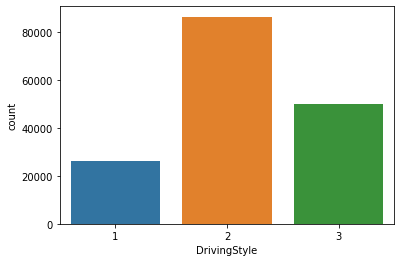

In [60]:
sns.countplot(x='DrivingStyle', data=driving_df)
pass

###3.Обработка пропущенных значений

Посмотрим количество пропущенных значений:

In [61]:
driving_df.isna().sum()

length                0
weight                0
axles                 0
DrivingStyle          0
road_lane             0
speed_previous        0
weight_previous       0
length_previous       0
time_gap           2455
road_condition        0
temperature        2057
precipitation         0
prec_intensity        0
humidity           2105
wind_direct        2114
wind_speed         2464
light                 0
delta                 0
dtype: int64

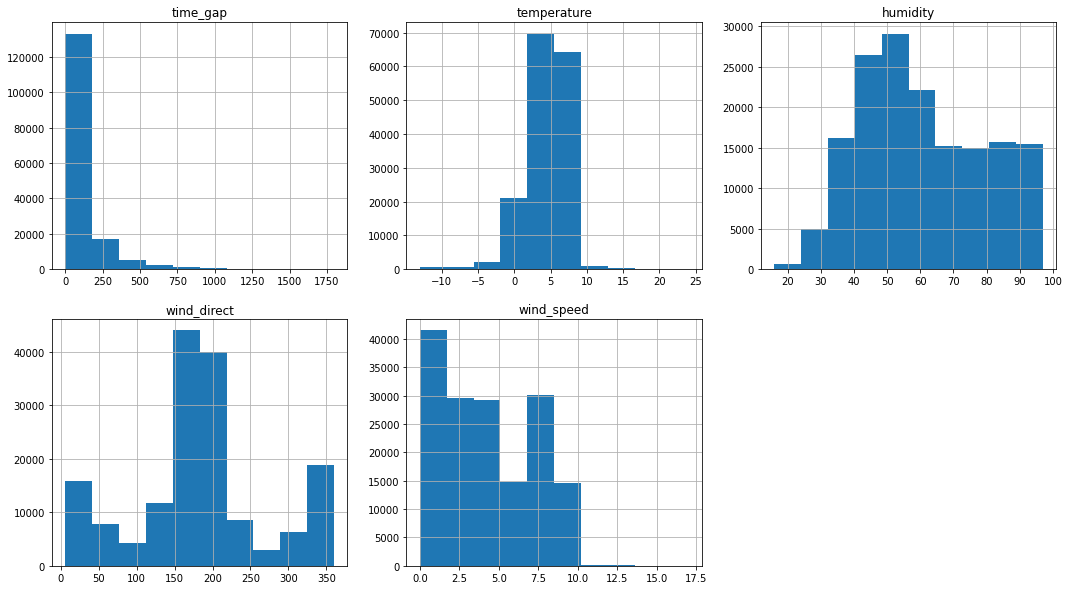

In [62]:
features = ["time_gap", "temperature", "humidity", "wind_direct", "wind_speed"]
plt.figure(figsize=(18,10))
for i in range(len(features)):
  plt.subplot(2,3, i+1)
  driving_df[features[i]].hist()
  plt.title(features[i])
pass

При таком распределении признака `time_gap` пропущенные значения лучше заменить медианой, т.к. длинный правый "хвост" может смещать значение среднего. <br>
Пропуски по остальным признакам можно заменить средним.

In [63]:
driving_df["time_gap"].fillna(driving_df["time_gap"].median(), inplace=True)
driving_df["temperature"].fillna(round(driving_df["temperature"].mean(), 0), inplace=True)
driving_df["humidity"].fillna(round(driving_df["humidity"].mean(), 0), inplace=True)
driving_df["wind_direct"].fillna(round(driving_df["wind_direct"].mean(), 0), inplace=True)
driving_df["wind_speed"].fillna(round(driving_df["wind_speed"].mean(), 0), inplace=True)

In [64]:
driving_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162561 entries, 0 to 162560
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   length           162561 non-null  int64   
 1   weight           162561 non-null  int64   
 2   axles            162561 non-null  int64   
 3   DrivingStyle     162561 non-null  int64   
 4   road_lane        162561 non-null  int64   
 5   speed_previous   162561 non-null  int64   
 6   weight_previous  162561 non-null  int64   
 7   length_previous  162561 non-null  int64   
 8   time_gap         162561 non-null  float64 
 9   road_condition   162561 non-null  category
 10  temperature      162561 non-null  float64 
 11  precipitation    162561 non-null  category
 12  prec_intensity   162561 non-null  category
 13  humidity         162561 non-null  float64 
 14  wind_direct      162561 non-null  float64 
 15  wind_speed       162561 non-null  float64 
 16  light            162

###4. Обработка категориальных признаков

In [65]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [66]:
ct = ColumnTransformer(
    [
        ("road_condition", OneHotEncoder(sparse=False, categories='auto'), ["road_condition"]),
        ("precipitation", OneHotEncoder(sparse=False, categories='auto'), ["precipitation"]),
        ("prec_intensity", OneHotEncoder(sparse=False, categories='auto'), ["prec_intensity"]),
        ("light", OneHotEncoder(sparse=False, categories='auto'), ["light"])
    ],
    remainder='drop'
)
ct.fit(driving_df)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('road_condition',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=False),
                                 ['road_condition']),
                                ('precipitation',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=False),
                                 ['precipitation']),
                                ('prec_intensity',
                                 OneHotEncoder(cat

In [67]:
one_hot_features = pd.DataFrame(ct.transform(driving_df), index=driving_df.index,
                                columns=[x.replace('__x0', '') for x in ct.get_feature_names()])

In [68]:
one_hot_features.head()

,road_condition_Dry,road_condition_Snow covered,road_condition_Visible tracks,road_condition_Wet,precipitation_clear,precipitation_rain,precipitation_snow,prec_intensity_,prec_intensity_High,prec_intensity_Low,prec_intensity_Moderate,prec_intensity_None,light_daylight,light_night,light_twilight
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


В принципе, признаки `precipitation_clear` и `prec_intensity_None` можно удалить, т.к. значения 0 у соответсвующих им других признаков будут говорить о том, что осадков нет

In [69]:
one_hot_features.drop(["precipitation_clear", "prec_intensity_None"], axis=1, inplace=True)

In [70]:
driving_df.drop(["road_condition", "precipitation", "prec_intensity", "light"], axis=1, inplace=True)

In [71]:
original_df = driving_df.join(one_hot_features)

In [72]:
original_df.head()

,length,weight,axles,DrivingStyle,road_lane,speed_previous,weight_previous,length_previous,time_gap,temperature,humidity,wind_direct,wind_speed,delta,road_condition_Dry,road_condition_Snow covered,road_condition_Visible tracks,road_condition_Wet,precipitation_rain,precipitation_snow,prec_intensity_,prec_intensity_High,prec_intensity_Low,prec_intensity_Moderate,light_daylight,light_night,light_twilight
0,1265,10243,2,2,1,87,16986,941,94.0,7.0,95.0,146.0,1.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1265,10243,2,2,1,81,1708,551,11.0,7.0,95.0,124.0,0.0,7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1265,10243,2,2,1,88,22892,1698,4.0,7.0,95.0,124.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1265,10243,2,2,2,89,1945,544,127.0,7.0,95.0,124.0,0.0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1265,10243,2,2,1,88,13787,1893,42.0,7.0,95.0,124.0,0.0,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


###5. Стандартизация количественных признаков

Проведем стандартизацию количественных признаков, т.к. значения разных признаков лежат в разных диапазонах

In [73]:
target_value = driving_df["DrivingStyle"]
driving_df.drop(["DrivingStyle"], axis=1, inplace=True)

In [74]:
driving_df = (driving_df - driving_df.mean(axis = 0))/driving_df.std(axis = 0)

In [75]:
driving_df.head()

,length,weight,axles,road_lane,speed_previous,weight_previous,length_previous,time_gap,temperature,humidity,wind_direct,wind_speed,delta
0,0.806882,0.529611,-0.577059,-1.001702,0.377850,1.617475,0.311686,-0.059048,0.730225,1.891991,-0.412624,-1.060279,-0.903784
1,0.806882,0.529611,-0.577059,-1.001702,-0.262513,-0.447286,-0.497530,-0.530586,0.730225,1.891991,-0.661636,-1.393094,-0.029866
2,0.806882,0.529611,-0.577059,-1.001702,0.484577,2.415648,1.882396,-0.570355,0.730225,1.891991,-0.661636,-1.393094,-0.903784
3,0.806882,0.529611,-0.577059,0.998294,0.591304,-0.415257,-0.512055,0.128432,0.730225,1.891991,-0.661636,-1.393094,-0.404402
4,0.806882,0.529611,-0.577059,-1.001702,0.484577,1.185143,2.287004,-0.354469,0.730225,1.891991,-0.661636,-1.393094,-0.279557


In [76]:
driving_df = driving_df.join(one_hot_features)

In [77]:
driving_df.head()

,length,weight,axles,road_lane,speed_previous,weight_previous,length_previous,time_gap,temperature,humidity,wind_direct,wind_speed,delta,road_condition_Dry,road_condition_Snow covered,road_condition_Visible tracks,road_condition_Wet,precipitation_rain,precipitation_snow,prec_intensity_,prec_intensity_High,prec_intensity_Low,prec_intensity_Moderate,light_daylight,light_night,light_twilight
0,0.806882,0.529611,-0.577059,-1.001702,0.377850,1.617475,0.311686,-0.059048,0.730225,1.891991,-0.412624,-1.060279,-0.903784,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.806882,0.529611,-0.577059,-1.001702,-0.262513,-0.447286,-0.497530,-0.530586,0.730225,1.891991,-0.661636,-1.393094,-0.029866,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.806882,0.529611,-0.577059,-1.001702,0.484577,2.415648,1.882396,-0.570355,0.730225,1.891991,-0.661636,-1.393094,-0.903784,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.806882,0.529611,-0.577059,0.998294,0.591304,-0.415257,-0.512055,0.128432,0.730225,1.891991,-0.661636,-1.393094,-0.404402,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.806882,0.529611,-0.577059,-1.001702,0.484577,1.185143,2.287004,-0.354469,0.730225,1.891991,-0.661636,-1.393094,-0.279557,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


###6. Обучающая и тестовая выборка

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
X = driving_df
y = target_value

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [81]:
X_train.shape

(130048, 26)

In [82]:
X_test.shape

(32513, 26)

In [83]:
y_train.value_counts(normalize=True)

2    0.532327
3    0.307348
1    0.160325
Name: DrivingStyle, dtype: float64

In [84]:
y_test.value_counts(normalize=True)

2    0.530495
3    0.308830
1    0.160674
Name: DrivingStyle, dtype: float64

###7. KNN

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [87]:
neigh = KNeighborsClassifier()

In [88]:
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [89]:
y_pred = neigh.predict(X_test)

In [90]:
confusion_matrix(y_test, y_pred)

array([[ 2852,  1698,   674],
       [ 1248, 13779,  2221],
       [ 1016,  2155,  6870]])

Измерим макро-метрики (среднее значение среди показателей для каждого класса)

In [91]:
precision = precision_score(y_test, y_pred, average='macro')
recall    = recall_score(y_test, y_pred, average='macro')
f1        = f1_score(y_test, y_pred, average='macro')
acc       = accuracy_score(y_test, y_pred)

print("Precision {}\nRecall {}\nF1-score {}\nAccuracy {}\n".format(precision, recall, f1, acc))

Precision 0.6808255524275107
Recall 0.6763372800899888
F1-score 0.6784845162625047
Accuracy 0.7228185648817396



Так как у нас несбалансированные классы, вычислим средневзвешенное значение по каждой метрике:

In [92]:
y_pred_train = neigh.predict(X_train)
precision = precision_score(y_train, y_pred_train, average='weighted')
recall    = recall_score(y_train, y_pred_train, average='weighted')
f1        = f1_score(y_train, y_pred_train, average='weighted')

print("On Train:\nPrecision {}\nRecall {}\nF1-score {}\n".format(precision, recall, f1))

On Train:
Precision 0.816152634784436
Recall 0.8168829970472441
F1-score 0.8164082648599259



In [93]:
precision = precision_score(y_test, y_pred, average='weighted')
recall    = recall_score(y_test, y_pred, average='weighted')
f1        = f1_score(y_test, y_pred, average='weighted')

print("On test:\nPrecision {}\nRecall {}\nF1-score {}\n".format(precision, recall, f1))

On test:
Precision 0.7214128014064713
Recall 0.7228185648817396
F1-score 0.7220135943917279



В среднем, классификатор с точностью до 72% верно определеяет тип вождения, а также верно находит 72% случаев определенного стиля вождения. 

**Подбор параметров**

На кросс-валидации попробуем подобрать гиперпараметр алгоритма (количество соседей).

In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [95]:
k_neighbours = [1, 3, 5, 7]

In [96]:
knn = KNeighborsClassifier()
skf = StratifiedKFold(n_splits=5, shuffle=True)
grid = GridSearchCV(knn, param_grid = {'n_neighbors': k_neighbours}, cv=skf, scoring='f1_weighted', n_jobs=-1)

In [97]:
%%time
grid.fit(X_train, y_train)

CPU times: user 1.81 s, sys: 114 ms, total: 1.93 s
Wall time: 13min 41s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='f1_weighted',
             verbose=0)

In [98]:
grid.best_score_

0.7174739425334771

In [99]:
grid.best_estimator_.n_neighbors

1

Судя по разнице метрик на обучающей и тестовой выборках, модель слегка недообучилась, подбор параметров не улучшил ситуацию. Возможно это связано со сложностью распределения данных. Кроме того, это может быть связано с несбалансированностью классов, о чем также свидетельствует оптимальное количество соседей, найденное перебором параметров и равное 1. Попробуем другие алгоритмы.

###8. Дерево решений

Дерево решений устойчиво к разным масштабам данных, поэтому можем использовать нестандартизованные данные.

In [100]:
from sklearn.tree import DecisionTreeClassifier

In [101]:
X = original_df.drop(["DrivingStyle"], axis=1)
y = original_df["DrivingStyle"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [102]:
dtree = DecisionTreeClassifier()

In [103]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [104]:
y_pred_train = dtree.predict(X_train)
precision = precision_score(y_train, y_pred_train, average='weighted')
recall    = recall_score(y_train, y_pred_train, average='weighted')
f1        = f1_score(y_train, y_pred_train, average='weighted')

print("On Train:\nPrecision {}\nRecall {}\nF1-score {}\n".format(precision, recall, f1))

On Train:
Precision 1.0
Recall 1.0
F1-score 1.0



In [105]:
y_pred = dtree.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall    = recall_score(y_test, y_pred, average='weighted')
f1        = f1_score(y_test, y_pred, average='weighted')

print("On test:\nPrecision {}\nRecall {}\nF1-score {}\n".format(precision, recall, f1))

On test:
Precision 0.9352284495038934
Recall 0.9351643957801494
F1-score 0.9351930032481992



In [106]:
params = [
          {
              "max_depth": [None, 5, 7, 10, 15],
              "min_samples_leaf": [1, 3, 5, 7, 10],
              "min_samples_split": [2, 5, 7, 10]
          }
]

In [107]:
dtree = DecisionTreeClassifier()
grid = GridSearchCV(dtree, param_grid=params, cv=skf, scoring='f1_weighted', n_jobs=-1)

In [108]:
%%time
grid.fit(X_train, y_train)

CPU times: user 13 s, sys: 1.34 s, total: 14.3 s
Wall time: 6min 26s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
        

In [109]:
grid.best_score_

0.9202818032134307

In [110]:
grid.best_params_

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Модель лучше всего работает с дефолтными параметрами. В целом, модель показала более высокий результат по сравнению с KNN, но по-прежнему недообучается. Попробуем использовать ансамбль деревьев.

###9. Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier

In [86]:
rf = RandomForestClassifier()

In [87]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [91]:
y_pred_train = rf.predict(X_train)
precision = precision_score(y_train, y_pred_train, average='weighted')
recall    = recall_score(y_train, y_pred_train, average='weighted')
f1        = f1_score(y_train, y_pred_train, average='weighted')

print("On Train:\nPrecision {}\nRecall {}\nF1-score {}\n".format(precision, recall, f1))

On Train:
Precision 1.0
Recall 1.0
F1-score 1.0



In [92]:
y_pred = rf.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall    = recall_score(y_test, y_pred, average='weighted')
f1        = f1_score(y_test, y_pred, average='weighted')

print("On test:\nPrecision {}\nRecall {}\nF1-score {}\n".format(precision, recall, f1))

On test:
Precision 0.9398986871508392
Recall 0.9399009626918463
F1-score 0.9398557813180789



С дефолтными параметрами (количество деревьев 100) случайный лес показал такой же результат, как одно дерево решений. На кросс-валидации посмотрим, как будет меняться качество модели с изменением числа деревьев.

In [95]:
from sklearn.model_selection import cross_val_score

In [93]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [94]:
scores = {
    1: [],
    2: [],
    5: [],
    10: [],
    50: [],
    100: [],
    150: [],
    200: [],
    300: [],
    400: [],
    500: []
}

In [96]:
for n in scores:
  if n == 1:
    bootstrap = False
  else:
    bootstrap = True

  rf = RandomForestClassifier(n_estimators=n, bootstrap=bootstrap)
  scores[n] = cross_val_score(rf, X_train, y_train, cv=skf, scoring='f1_weighted')

In [97]:
scores = pd.DataFrame(scores)
scores.columns = [str(x) for x in scores.columns]

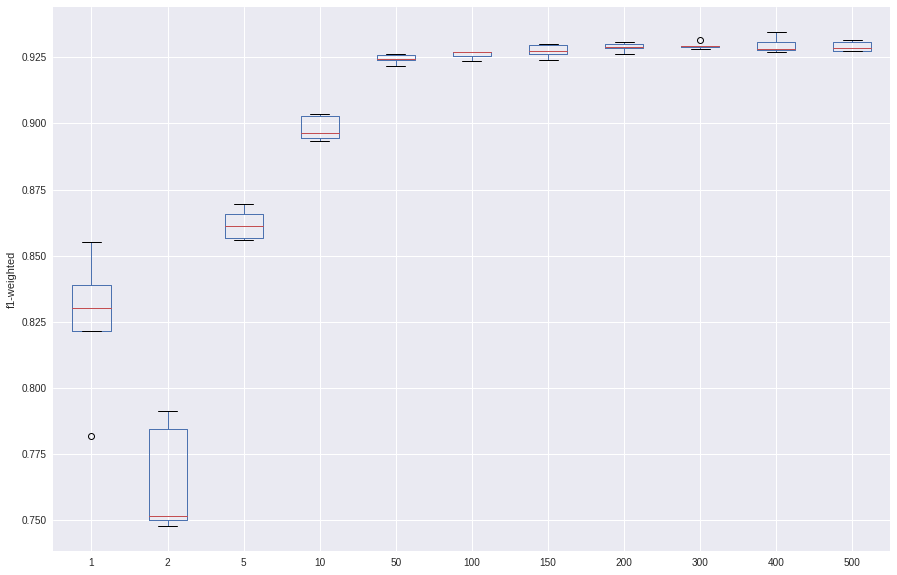

In [104]:
plt.figure(figsize=(15,10))
scores.boxplot()
plt.ylabel('f1-weighted')
plt.show()

In [106]:
scores.median()

1      0.830335
2      0.751558
5      0.861159
10     0.896272
50     0.924338
100    0.927056
150    0.927341
200    0.928774
300    0.929315
400    0.928080
500    0.928625
dtype: float64

In [107]:
scores.describe()

,1,2,5,10,50,100,150,200,300,400,500
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.825519,0.765112,0.861879,0.898105,0.924454,0.926049,0.927551,0.928901,0.929441,0.929584,0.929201
std,0.027497,0.021055,0.005801,0.004713,0.001749,0.001555,0.002479,0.001774,0.001189,0.003140,0.001906
min,0.781710,0.747773,0.856097,0.893418,0.921825,0.923583,0.924138,0.926290,0.928226,0.926869,0.927458
25%,0.821346,0.750261,0.856755,0.894564,0.924008,0.925419,0.926398,0.928382,0.928877,0.927737,0.927498
50%,0.830335,0.751558,0.861159,0.896272,0.924338,0.927056,0.927341,0.928774,0.929315,0.928080,0.928625
75%,0.838952,0.784655,0.865844,0.902708,0.925956,0.927084,0.929666,0.930220,0.929387,0.930620,0.930901
max,0.855251,0.791310,0.869540,0.903565,0.926144,0.927101,0.930212,0.930835,0.931401,0.934615,0.931520


Можно остановиться на 50 деревьях, т.к. дальше качество начинается варьироваться в маленьком диапазоне. Подберем параметры для деревьев в лесу.

In [111]:
params = [
          {
              "max_depth": [None, 5, 10, 15],
              "max_features": [3, 5, 7, 10]
          }
]

In [112]:
rf = RandomForestClassifier(n_estimators=50)
grid = GridSearchCV(rf, param_grid=params, cv=skf, scoring='f1_weighted', n_jobs=4, verbose=5)

In [113]:
%%time 
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  7.0min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  9.3min finished


CPU times: user 27.5 s, sys: 1.67 s, total: 29.2 s
Wall time: 9min 41s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                           

In [114]:
grid.best_score_

0.9552707154465271

In [115]:
grid.best_params_

{'max_depth': None, 'max_features': 10}

In [116]:
rf = RandomForestClassifier(n_estimators=50, max_features=10)

In [117]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [118]:
y_pred_train = rf.predict(X_train)
precision = precision_score(y_train, y_pred_train, average='weighted')
recall    = recall_score(y_train, y_pred_train, average='weighted')
f1        = f1_score(y_train, y_pred_train, average='weighted')

print("On Train:\nPrecision {}\nRecall {}\nF1-score {}\n".format(precision, recall, f1))

On Train:
Precision 0.9999846225380484
Recall 0.9999846210629921
F1-score 0.9999846213206977



In [119]:
y_pred = rf.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall    = recall_score(y_test, y_pred, average='weighted')
f1        = f1_score(y_test, y_pred, average='weighted')

print("On test:\nPrecision {}\nRecall {}\nF1-score {}\n".format(precision, recall, f1))

On test:
Precision 0.9673394680529074
Recall 0.9673361424660905
F1-score 0.9673377399337525



Качество обучающей и тестовой выборках получилось вполне хорошим, модель смогла дообучиться. Оставим это как итоговый вариант.